In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
azeri_light = pd.read_excel('data/decomposition/azeri_light.xlsx')
brent = pd.read_excel('data/decomposition/brent.xls')
gdp = pd.read_csv('data/decomposition/gdp.csv')
loan_history = pd.read_csv('data/decomposition/loan_history.csv')


In [3]:
print(azeri_light)
print(brent)
print(gdp)
print(loan_history)


            Day  Azeri_Light
0    2000-01-04        27.45
1    2000-01-05        27.22
2    2000-01-06        27.05
3    2000-01-07        26.85
4    2000-01-10        26.27
...         ...          ...
6554 2025-10-28        66.23
6555 2025-10-29        67.21
6556 2025-10-30        67.31
6557 2025-10-31        67.64
6558 2025-11-03        67.99

[6559 rows x 2 columns]
          Date  price
0   1987-05-15  18.58
1   1987-06-15  18.86
2   1987-07-15  19.86
3   1987-08-15  18.98
4   1987-09-15  18.31
..         ...    ...
457 2025-06-15  71.44
458 2025-07-15  71.04
459 2025-08-15  67.87
460 2025-09-15  67.99
461 2025-10-15  64.54

[462 rows x 2 columns]
    Year  GDP_current_USD
0   1960              NaN
1   1961              NaN
2   1962              NaN
3   1963              NaN
4   1964              NaN
..   ...              ...
60  2020     4.269300e+10
61  2021     5.482541e+10
62  2022     7.880747e+10
63  2023     7.242847e+10
64  2024     7.431588e+10

[65 rows x 2 columns]
    

<Axes: xlabel='Day', ylabel='Azeri_Light'>

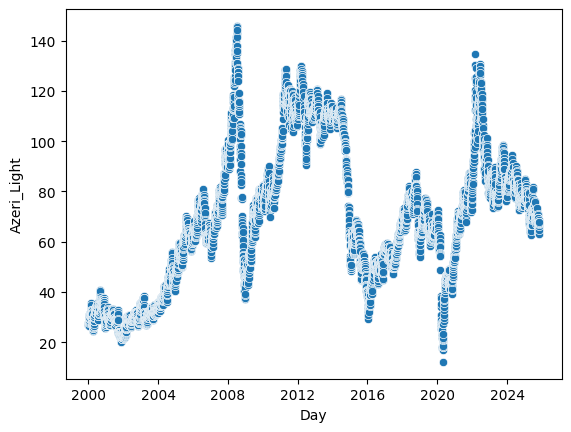

In [22]:
sns.scatterplot(data=azeri_light, x="Day", y="Azeri_Light")
# sns.lineplot(data=azeri_light, x="Day", y="Azeri_Light")
# sns.relplot(data=azeri_light, x="Day", y="Azeri_Light")
# sns.violinplot(data=azeri_light, x="Day") #, y="Azeri_Light")
# sns.histplot(data=azeri_light, x="Day") #, y="Azeri_Light")
# sns.kdeplot(data=azeri_light, x="Day") #, y="Azeri_Light")
# sns.displot(data=azeri_light, x="Day") #, y="Azeri_Light")
# sns.ecdfplot(data=azeri_light, x="Day") #, y="Azeri_Light")
